In [43]:
import numpy as np
import pandas as pd
from scipy import stats 
import typing
import tqdm
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [44]:
datos=pd.read_csv('Datos\CarPrice_Assignment.csv',index_col=0)
datos.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [45]:
datos.isna().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [46]:
datos.corr().style.background_gradient(cmap='coolwarm')

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,-0.178515,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984


A continuación se resentan un conjunto de datos de las características de distintos vehículos con sus respectivos precios. Es de interés pronosticar el precio del vehículo, para ello emplearemos una regresión lineal múltiple con regularización Ridge construida desde cero

# Preprocesamiento

In [47]:
escalador=MinMaxScaler()

In [48]:
y=np.array(datos['price'])
x=datos.drop(['price'],axis=1)
x=x.loc[:,['symboling','wheelbase','carlength','carwidth','carheight',	'curbweight','enginesize','boreratio','horsepower','peakrpm','citympg','highwaympg']]
X=escalador.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# Construcción del modelo

In [49]:
class Ridge:
    coef: float
    #valor alpha para la penalización l2
    def __init__(self,alpha):
        self.alpha=float(alpha)
    
    #para esimar los coeficientes de acuerdo a la función de perdida
    def gradient(self,x,y,coef):
        err=y-np.dot(x,coef)#error de pronostico (y-y^)
        return -2*err*x #mutiplica el 2*error por cada vector de x 
    
    def det_coef(self,coef,dxi_loss,learning_rate):
        coef-=dxi_loss[0]*np.array([learning_rate])
        reg=(2*np.array([self.alpha]))*coef#penalizacion al gradiente
        coef+=reg
        return coef
    
    #para entrenar el modelo
    def fit(self,x_train,y_train,learning_rate=0.001,epochs=1000,batch_size=27,random_s=None):
        np.random.seed(random_s)
        self.x_train=x_train
        self.y_train=y_train
        self.coef=np.random.randn(self.x_train.shape[1])#np.random.randn(x_train.shape[1])
        
        for t in tqdm.trange(epochs):
            for i in range(0,len(self.x_train),batch_size):
                b_xt=self.x_train[i:i+batch_size]
                b_yt=self.y_train[i:i+batch_size]
                    
                #para calcular el gradiente, dependiendo del tamaño del batch se calcula el promedio de la derivada parcial para el movimiento de cada beta
                dxi_loss=np.mean([[self.gradient(xi,yi,self.coef)]for xi,yi in zip(b_xt,b_yt)],axis=0)#np.mean(,axis=0)
                #print(dxi_loss.shape)
                #para estimar los coeficientes de acuerdo a los resultados del gradiente
                self.coef=self.det_coef(self.coef,dxi_loss,learning_rate)
                
    #permite obtener estadisticas de la signifiancia individual de cada coeficiente
    def standard_error(self,name_var=None):
        #suma de cuadrados de los residuos
        sse=sum((self.y_train-self.predict(x_train))**2)
        #varianza residual con dos grados de libertad
        sigma2=sse/(y_train.shape[0]-2)
        #coovarinza de los coeficientes
        try:
            inversa=np.linalg.inv(np.dot(self.x_train.T,self.x_train))
        except:
            pass
        cov=(sigma2*inversa)
        #raiz de la varianza de los betas
        StdErrorB=np.sqrt(np.diag(cov))
        #error estaandar
        statistic=self.coef/StdErrorB
        #se prueba los erroes en una distribución t con 2 grados de libertad
        p_val=(1-(stats.t(df=2).cdf(statistic)))
        print('\t***********************************************')
        print('\t Significancia individual de los coeficientes  ')
        print('\t-----------------------------------------------')
        if name_var==None:
            st_cof=pd.DataFrame({'Coeficientes':self.coef,'P Value':p_val,'Estadístico':statistic},index=name_var)
            print(f'{st_cof}')

        else:            
           st_cof=pd.DataFrame({'Coeficientes':self.coef,'P Value':p_val,'Estadístico':statistic},index=name_var)
           print(f'{st_cof}')
           
    #pronostica los resultados de acuerdo a los datos de entrenamiento
    def predict(self,x_test):
        return np.dot(x_test,self.coef)

# Creación de la instancia con su respectivo nivel de regularización  y entrenamiento

In [50]:
modelo=Ridge(0.0001)

In [51]:
modelo.fit(x_train,y_train,learning_rate=.01,random_s=123)

100%|██████████| 1000/1000 [00:08<00:00, 112.80it/s]


# Evaluación del modelo y obtención de estadístocs

In [52]:
resultados=modelo.predict(x_test)

In [53]:
modelo.standard_error(x.columns.to_list())

	***********************************************
	 Significancia individual de los coeficientes  
	-----------------------------------------------
            Coeficientes   P Value  Estadístico
symboling    -314.108241  0.573691    -0.210731
wheelbase    -924.171184  0.563589    -0.181328
carlength   -9341.111493  0.900308    -1.889661
carwidth     6928.570054  0.105555     1.815449
carheight    4178.270090  0.097568     1.917985
curbweight  13850.915213  0.059755     2.626634
enginesize  26001.183643  0.016241     5.412471
boreratio   -5713.060071  0.950430    -2.934769
horsepower  15734.710622  0.046345     3.051716
peakrpm      1227.157717  0.290662     0.651991
citympg       382.611784  0.483890     0.045589
highwaympg    459.032451  0.479910     0.056869


In [54]:
resultados=modelo.predict(x_test)

In [55]:
r2_score(y_test,resultados)

0.9311950410980822

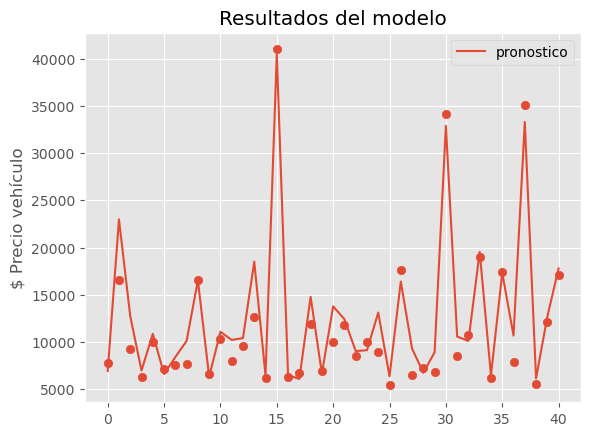

In [56]:
plt.scatter(x=range(0,y_test.shape[0]),y=y_test)
plt.plot(resultados,label='pronostico')
plt.title('Resultados del modelo')
plt.ylabel('$ Precio vehículo')
plt.legend()
plt.show()